In [1]:
from functions import *

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import glob

## CNN

In [18]:
W = 256
source_path = '../data/preprocessed/'
data_paths = ['lst', 'ndvi', 'wt', 'masked']#, 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {k:[] for k in data_paths}

for i,dir_p in enumerate(dir_paths):
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p and not subdir.endswith('masked'): #and rivers_count < max_rivers:
            all_dir_paths[data_paths[i]].append(subdir)
        elif subdir.endswith('masked'):
            all_dir_paths['masked'].append(subdir)


all_dir_paths    

{'lst': ['../data/preprocessed/lst/Wasserfallenbach',
  '../data/preprocessed/lst/Eibachli',
  '../data/preprocessed/lst/Bisse-Neuf',
  '../data/preprocessed/lst/LaVenoge_shapefile',
  '../data/preprocessed/lst/le_boiron2',
  '../data/preprocessed/lst/I_Custiell',
  '../data/preprocessed/lst/La_Paudeze',
  '../data/preprocessed/lst/Zauggenbach',
  '../data/preprocessed/lst/Aletenbach',
  '../data/preprocessed/lst/Alplibach',
  '../data/preprocessed/lst/Plattenbach',
  '../data/preprocessed/lst/swissTLMboiron',
  '../data/preprocessed/lst/LaBroye_shapefile'],
 'ndvi': ['../data/preprocessed/ndvi/Wasserfallenbach',
  '../data/preprocessed/ndvi/Eibachli',
  '../data/preprocessed/ndvi/Bisse-Neuf',
  '../data/preprocessed/ndvi/LaVenoge_shapefile',
  '../data/preprocessed/ndvi/le_boiron2',
  '../data/preprocessed/ndvi/I_Custiell',
  '../data/preprocessed/ndvi/La_Paudeze',
  '../data/preprocessed/ndvi/Zauggenbach',
  '../data/preprocessed/ndvi/Aletenbach',
  '../data/preprocessed/ndvi/Alpliba

In [19]:
total_data = {}
total_times = {}
filter_river = None
for k,v in all_dir_paths.items():
    if k == 'lst' or k == 'masked':
        list_rgb = [True]*len(v)
    else:
        list_rgb = [False]*len(v)
    
    if filter_river != None:
        v = [v[filter_river]]
    print('getting data for path',v) 
    data, times = load_data(v,W,list_rgb)
    
    #d = [item for sublist in data.values() for item in sublist]
    total_data[k] = np.concatenate(list(data.values()), axis=0)
    total_times[k] = times
    print(k,':' ,total_data[k].shape)
    

getting data for path ['../data/preprocessed/lst/Wasserfallenbach', '../data/preprocessed/lst/Eibachli', '../data/preprocessed/lst/Bisse-Neuf', '../data/preprocessed/lst/LaVenoge_shapefile', '../data/preprocessed/lst/le_boiron2', '../data/preprocessed/lst/I_Custiell', '../data/preprocessed/lst/La_Paudeze', '../data/preprocessed/lst/Zauggenbach', '../data/preprocessed/lst/Aletenbach', '../data/preprocessed/lst/Alplibach', '../data/preprocessed/lst/Plattenbach', '../data/preprocessed/lst/swissTLMboiron', '../data/preprocessed/lst/LaBroye_shapefile']
lst : (119, 256, 256, 3)
getting data for path ['../data/preprocessed/ndvi/Wasserfallenbach', '../data/preprocessed/ndvi/Eibachli', '../data/preprocessed/ndvi/Bisse-Neuf', '../data/preprocessed/ndvi/LaVenoge_shapefile', '../data/preprocessed/ndvi/le_boiron2', '../data/preprocessed/ndvi/I_Custiell', '../data/preprocessed/ndvi/La_Paudeze', '../data/preprocessed/ndvi/Zauggenbach', '../data/preprocessed/ndvi/Aletenbach', '../data/preprocessed/ndv

In [20]:
r,m=load_raster('../data/preprocessed/discharge/discharge_k.tif', False)

In [21]:
discharge_lebroye = resize_image(r, W,W)
discharge_lebroye.shape

(256, 256)

In [22]:
lst = total_data['lst']
ndvi = total_data['ndvi']
data_targets = total_data['wt']
#wt_stations = data[dir_paths[3]]
print('inputs shape:', lst.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (119, 256, 256, 3) (119, 256, 256)
targets shape: (119, 256, 256)


In [23]:
inputs = 'ndvi,lst'#discharge'

In [24]:
disch_lebroye= np.tile(discharge_lebroye, (lst.shape[0], 1, 1))
disch_lebroye.shape

(119, 256, 256)

In [25]:
if inputs == 'lst':
    train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(lst, data_targets)
else:
    # Lista de diferentes conjuntos de imágenes a combinar con LST
    additional_images = [ndvi]#, disch_lebroye]  # Añade todas las imágenes adicionales que quieras

    # Expande la dimensión de cada conjunto de imágenes para asegurar que tengan un canal extra
    expanded_images = [np.expand_dims(img, axis=-1) for img in additional_images]  # Cada imagen tendrá shape: (n_samples, 256, 256, 1)

    # Concatenar LST con todas las imágenes adicionales a lo largo del último eje (canales)
    combined_input = np.concatenate([lst] + expanded_images, axis=-1)  # LST (RGB) + todas las imágenes adicionales
    # Shape final: (n_samples, 256, 256, n_channels) donde n_channels depende del número de conjuntos de imágenes

    # Ahora puedes usar 'combined_input' para el resto del procesamiento
    train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(combined_input, data_targets)


In [26]:
train_input.shape

(97, 256, 256, 4)

In [27]:
if inputs == 'lst':
  train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(lst, data_targets)
else:
  ndvi_expanded = np.expand_dims(ndvi, axis=-1)  # Shape: (n_samples, 256, 256, 1)

  # Combine LST (RGB) y NDVI in a 4 channel input data
  combined_input = np.concatenate([lst, ndvi_expanded], axis=-1)  # Shape: (n_samples, 256, 256, 4)
  train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(combined_input, data_targets)

## Choose hyperparameters

In [28]:
batch_size = 4
epochs = 50

### Build model

In [29]:
from tensorflow.keras import layers, models
import tensorflow as tf


def build_simplified_cnn_model(input_shape):
    model = models.Sequential()

    # Capa 1: Convolucional + ReLU + Max Pooling
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa 2: Convolucional + ReLU + Max Pooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa 3: Convolucional + Upsampling para mantener la resolución original
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))  # Escalar de nuevo

    # Capa 4: Convolucional + Upsampling
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))  # Escalar de nuevo

    # Capa de salida con predicción pixel a pixel, con 1 canal
    model.add(layers.Conv2D(1, (1, 1), activation='linear'))  # 1 canal para salida de un solo valor (escala de grises o similar)

    return model


In [30]:
if len(train_input.shape) == 3:
  input_shape = train_input.shape[1:]+(1,)
else:
  input_shape = train_input.shape[1:]  # Assuming data_inputs is your dataset


In [31]:
simplified_cnn_model = build_simplified_cnn_model(input_shape)
simplified_cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
simplified_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 16)      592       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 128, 128, 64)     

In [32]:
history = simplified_cnn_model.fit(train_input, train_target, batch_size=batch_size, epochs=epochs, validation_data=(validation_input, validation_target))

Epoch 1/50
25/25 [==============================] - 3s 104ms/step - loss: 1.3426 - mae: 0.1918 - val_loss: 2.1837 - val_mae: 0.2180
Epoch 2/50
25/25 [==============================] - 2s 98ms/step - loss: 1.3391 - mae: 0.1950 - val_loss: 2.1835 - val_mae: 0.2139
Epoch 3/50
25/25 [==============================] - 3s 101ms/step - loss: 1.3391 - mae: 0.1992 - val_loss: 2.1839 - val_mae: 0.2077
Epoch 4/50
25/25 [==============================] - 3s 112ms/step - loss: 1.3383 - mae: 0.1997 - val_loss: 2.1819 - val_mae: 0.2249
Epoch 5/50
25/25 [==============================] - 3s 106ms/step - loss: 1.3382 - mae: 0.2095 - val_loss: 2.1823 - val_mae: 0.2205
Epoch 6/50
25/25 [==============================] - 3s 104ms/step - loss: 1.3389 - mae: 0.1944 - val_loss: 2.1821 - val_mae: 0.2231
Epoch 7/50
25/25 [==============================] - 2s 96ms/step - loss: 1.3378 - mae: 0.2059 - val_loss: 2.1816 - val_mae: 0.2467
Epoch 8/50
25/25 [==============================] - 2s 92ms/step - loss: 1.337

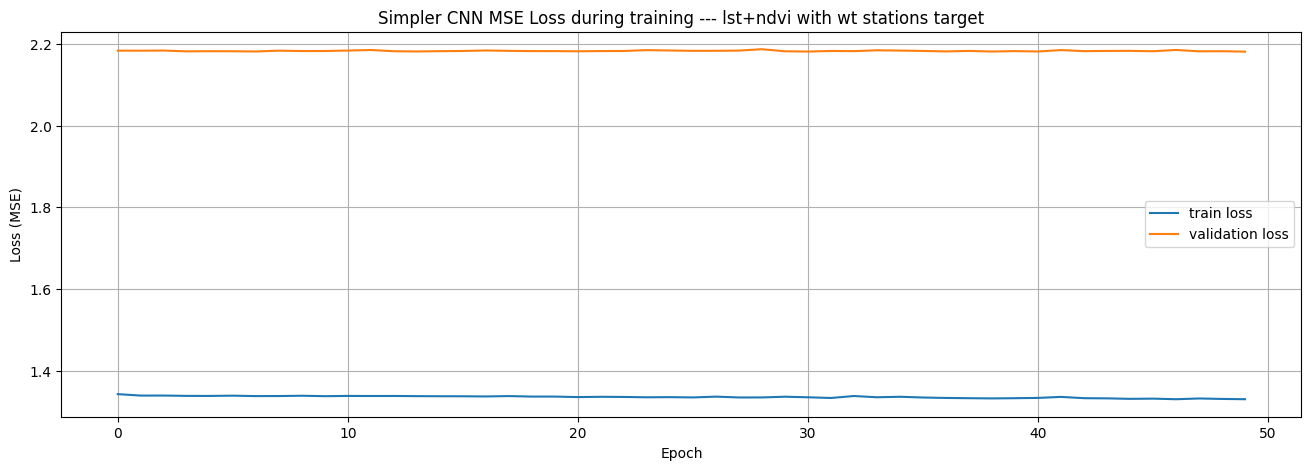

In [33]:
plt.figure(figsize=(16,5))
#plt.clf
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Simpler CNN MSE Loss during training --- lst+ndvi with wt stations target')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

### Validate and test

In [34]:
validation_prediction = simplified_cnn_model.predict(validation_input)
test_prediction = simplified_cnn_model.predict(test_input)

1/1 [==============================] - 0s 132ms/step


In [35]:
validation_target_flat = validation_target.reshape(-1)
validation_prediction_flat = validation_prediction.reshape(-1)

test_target_flat = test_target.reshape(-1)
test_prediction_flat = test_prediction.reshape(-1)

In [36]:
val_target_mask = validation_target_flat[validation_target_flat!= 0]
val_pred_mask = validation_prediction_flat[validation_target_flat!= 0]
test_target_mask = test_target_flat[test_target_flat!= 0]
test_pred_mask = test_prediction_flat[test_target_flat!= 0]

In [37]:
results = evaluate_model(test_target_mask, test_pred_mask)
print('Test results')
for k,v in results.items():
  print(k,':',v)

Test results
MAE : 10.528595
MSE : 92.9094
RMSE : 12.804861
R² : -2.073020657941743
MAPE (%) : 93.6126708984375
MSE sample-wise : 163.96446


Image wise metrics results

In [38]:
c = 0
mean_results = {k:[] for k in results.keys()}
# Loop through each sample and compute the MSE for that sample
for i in range(test_target.shape[0]):
    samples_per_image = test_target.shape[1]*test_target.shape[2]
    # Flatten the true and predicted values for this sample
    y_true_flatten = test_target_flat[c:c+samples_per_image]
    y_true_mask = y_true_flatten[y_true_flatten!= 0]

    y_pred_flatten = test_prediction_flat[c:c+samples_per_image]
    y_pred_mask = y_pred_flatten[y_true_flatten!= 0]

    #print(y_true_flatten.shape,y_pred_flatten.shape)
    # Calculate MSE for this sample
    mse = mean_squared_error(y_true_mask, y_pred_mask)
    res = evaluate_model(y_true_mask, y_pred_mask)

    for k,v in res.items():
      mean_results[k].append(v)


    c += samples_per_image

for key in mean_results:
    mean_results[key] = np.mean(mean_results[key])

print(mean_results)

{'MAE': 10.6485815, 'MSE': 167.06946, 'RMSE': 10.691329, 'R²': -34275831952821.676, 'MAPE (%)': 93.98580518635836, 'MSE sample-wise': 164.52269}


#### Save model results

In [39]:
model_name = "pixel_wise_CNN"
details = {'RMSE':mean_results['RMSE'],'Variables':inputs,'Input': '10 rivers', 'Output': 'wt', 'Resolution': 256, 'nº samples': len(data_targets), 'Batch size': batch_size, 'Epochs': epochs}

file_path = f"../results/{model_name}_results.xlsx"
save_excel(file_path, details, excel = 'Results')

mean_results['Model'] = model_name
file_path = f"../results/all_results.xlsx"
save_excel(file_path, mean_results, excel = 'Results')